## Installing graph-tool (https://graph-tool.skewed.de)

To import a library that's not in Colaboratory by default, you can use !apt-get install.
But since graph-tool is not in the official repository, we need to add it to the list.

In [7]:
!echo "deb http://downloads.skewed.de/apt bionic main" >> /etc/apt/sources.list
!apt-key adv --keyserver keyserver.ubuntu.com --recv-key 612DEFB798507F25
!apt-get update
!apt-get install python3-graph-tool python3-matplotlib python3-cairo

Executing: /tmp/apt-key-gpghome.q2ttzoto6s/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-key 612DEFB798507F25
gpg: key 612DEFB798507F25: 8 signatures not checked due to missing keys
gpg: key 612DEFB798507F25: public key "Tiago de Paula Peixoto <tiago@skewed.de>" imported
gpg: Total number processed: 1
gpg:               imported: 1
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages [770 kB]
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:8 http://ppa.launchpad.net/c2d4u.

In [8]:
#python3-cairo from Ubuntu's reposity is linked with a different python version; we need to improvise
!apt purge python3-cairo
!apt install libcairo2-dev pkg-config python3-dev
!pip install --force-reinstall pycairo
!pip install zstandard

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'apt autoremove' to remove them.
The following packages will be REMOVED:
  python3-cairo*
0 upgraded, 0 newly installed, 1 to remove and 74 not upgraded.
After this operation, 257 kB disk space will be freed.
(Reading database ... 158974 files and directories currently installed.)
Removing python3-cairo:amd64 (1.16.2-1) ...
Reading package lists... Done
Building dependency tree       
Reading state information... Done
pkg-config is already the newest version (0.29.1-0ubuntu2).
python3-dev is already the newest version (3.6.7-1~18.04).
python3-dev set to manually installed.
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'apt autoremove' to remove them.
The following additional pack

# SVM Experiment

In [1]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

1.11.0+cu113
     |████████████████████████████████| 7.9 MB 8.3 MB/s 
     |████████████████████████████████| 3.5 MB 8.1 MB/s 


In [2]:
# install ogb

!pip install ogb

     |████████████████████████████████| 78 kB 4.2 MB/s 
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7048 sha256=4517c20b57f50e9a2513d8e80428a7d4a6b4af0b0f66f46c3fcf5d4b2bc6bf78
  Stored in directory: /root/.cache/pip/wheels/d6/64/cd/32819b511a488e4993f2fab909a95330289c3f4e0f6ef4676d
Successfully built littleutils


In [3]:
import torch
from torch_geometric.data import Data
from torch_geometric.datasets import TUDataset, ZINC
import torch_geometric.utils as uts
from torch_geometric.utils import remove_self_loops, to_undirected

import numpy as np
import matplotlib.pyplot as plt
import itertools
from tqdm import tqdm

In [9]:
# Graph libraries

import networkx as nx 
from networkx.algorithms.isomorphism import ISMAGS, GraphMatcher

import graph_tool as gt
import graph_tool.topology as gt_topology

In [5]:
from ogb.graphproppred import PygGraphPropPredDataset

#### Load the drive for data files:

In [29]:
#from google.colab import drive
#drive.mount('/content/drive')
# Mount the current directory
#%cd /content/drive/My\ Drive//CS159_project

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/CS159_project


## Graph processing code

Encoders

In [10]:
def gt_Encoder_old(G, F_set ,symmetry = True, induced = False, format = 'Torch'):
    '''
    This function returns the subgraph isomorphism vector in R^|F_set| given by (subgraphIso(F,G)) 
    
    Inputs:
        G: Graph
        F_set (N, ): The set of test subgraphs, with each subgraph specifing full or line
        symmetry (optional, default = True) : counting embeddings F->G up to automorphisms of F or not. 
        induced (optional, default = False) : If True, only node-induced subgraphs are found.
        format (optional, default = Torch): desired output type
    Output:
        Enc(G): (N, ) vector of subgraph isomorphism counting
    '''
    # convert torch.geometric.data to gt_tools graph
    
    graph = torch_to_gt_tools(G)
    subIso = lambda x,y,n: gt_topology.subgraph_isomorphism(x,y,max_n = n, induced = induced)
    subIso_G = (subIso(F,graph,n) for F,n in F_set)
    numSubIso_G = map(lambda x: len(list(x)),subIso_G)

    # match format 
    if format == 'Torch':
        return torch.tensor(list(numSubIso_G))
    if format == 'numpy':
        return np.array((list(numSubIso_G))) 
 
def Simple_Encoder(G, F_set ,symmetry = True, line = True, format = 'Torch'):
    '''
    This function returns the subgraph isomorphism vector in R^|F_set| 
    given by (subgraphIso(F,G)) computed by graph_tools
    
    Inputs:
        G: Graph
        F_set (N, ): The set of test subgraphs, with each subgraph specifing full or line
        symmetry (default = True) : counting embeddings F->G up to automorphisms of F or not. 
        line (default = True) : whether to consider full subgraphs of line graph
        format (default = Torch): desired output type
    Output:
        Enc(G): (N, ) vector of subgraph isomorphism counting
    '''
    Isom = lambda x,y: ISMAGS(nx.line_graph(x),nx.line_graph(y)) if line else ISMAGS(x,y)
    Isom_G = (Isom(G,F) for F in F_set)
    numIso_G = map(lambda x: len(list(x.find_isomorphisms(symmetry))), Isom_G)

    # match format 
    if format == 'Torch':
        return torch.tensor(list(numIso_G))
    if format == 'numpy':
        return np.array((list(numIso_G)))
    pass

### Enriched embedding classses

In [11]:
####### converters ######################

def kx_to_gt(F):
  '''
  convert a networkX graph to gt_tools graph
  '''
  edge_list = F.edges
  graph = gt.Graph(directed=False)
  graph.add_edge_list(edge_list)
  gt.stats.remove_self_loops(graph)
  gt.stats.remove_parallel_edges(graph)

  return graph

def torch_to_nx(G):
    return uts.to_networkx(G, to_undirected = True)

def torch_to_gt_tools(G):
    '''
    convert torch.geometric.data to gt_tools graph
    '''
    return kx_to_gt(torch_to_nx(G))

In [12]:
#################################################

# Enriched encoders and test graph classes

#################################################

####### testgraph class ##########
class testGraph: 
  '''
  A class object for a test graph with descriptive features
  '''
  def __init__(self, graph, graph_name = None, max_n = 0, format = 'networkx'):
    '''
     Parameters:
     graph: a graph in the format "format" (default is networkX)
     graph_name (String): the name of a graph 
     max_n (Int): a bound for the number of subgraphs taken
    '''
    self.name = graph_name
    self.__graph = graph
    self.bound = max_n
    self.format = format
  def gt_graph(self):
    '''
     returns the graph in graph_tools format
    '''
    return kx_to_gt(self.__graph)
  def nx_graph(self):
    '''
     returns the graph in networkX format
    '''
    return self.__graph
  def pyg_graph(self):
    if self.format != 'networkx':
      raise Exception('Not implemented yet')
    return uts.convert.from_networkx(self.__graph)
  def draw(self):
    '''
     returns a drawing of the graph
    '''
    if self.format != 'networkx':
      return None
    return nx.draw(self.nx_graph())

###########################################################################


####### embedding class ##########

      
class gt_embedding:
  '''
  A class for for handeling the embeddings from subgraph isomorphism. 
  '''
  def __init__(self, graph, 
               testgraphs = None , 
               symmetry = True, 
               induced = False, 
               format = 'Torch'):
    self.__graph = graph
    self.graph = self.__graph
    if testgraphs == None: 
        self.testgraphs = {}
    else:
        self.testgraphs = testgraphs
    self.symmetry = symmetry
    self.induced = induced
    self.format = format
  def gt_graph(self):
    '''
     returns the encoded graph in graph_tools format
    '''
    if self.format == 'networkx':
      return kx_to_gt(self.__graph)
    # in the future we will have more formats, now just assume else is networkx
    return torch_to_gt_tools(self.__graph)
  def nx_graph(self):
    '''
     returns the encoded graph in networkX format
    '''
    if self.format == 'networkx':
        return self.__graph
    if self.format == 'Torch':
        return torch_to_nx(self.__graph)
    else:
      raise Exception('Not implemented yet')
  def pyg_graph(self):
    if self.format == 'Torch':
      return self.__graph
    else:
      raise Exception("Not implemented yet")
  def draw_graph(self):
    '''
     returns a drawing of the encoded graph
    '''
    return nx.draw(self.nx_graph())
  def add(self, test_graph):
    '''
     Adds a graph to the set of test graphs
     parameters:
     test_graph (testGraph) : graph to be added
    '''
    self.testgraphs[test_graph.name] = test_graph
  def add_from_iter(self, testgraphs):
    '''
     Adds graphs from an iterrable (e.g. list) to the set of test graphs
     parameters:
     testgraphs (testGraph) : iterator of graphs to be added
    '''
    dict_new_testgraphs = {F.name : F for F in testgraphs}
    self.testgraphs.update(dict_new_testgraphs)
  def __subIso(self, testgraph):
    # returns a list of subgraphs testgraphs -> graph
    return gt_topology.subgraph_isomorphism(testgraph.gt_graph(), 
                                            self.gt_graph(), 
                                            max_n = testgraph.bound, 
                                            induced = self.induced)
  def subIso(self, testgraph):
    # a public version of subIso, might be revoked in the future
      return self.__subIso(testgraph)
  def subIsodict(self):
    return {k: self.__subIso(v) for k, v in self.testgraphs.items()}
  def __pullback(self, testgraph, embedding,  format = 'Torch'):
    # returns the testgraph with features pulled back from the target graph along a map embedding
    '''
    input:
    testgraph (testGraph): a testgraph 
    embedding (gt.vertexpropertymap) :  an embedding of testgraph into the graph
    returns:
    subgraph (torch-geometric.data): testgraph as pyg data with features pulled along embedding
    '''
    if self.format != 'Torch':
      raise Exception('Not implemented yet')
    subgraph = testgraph.pyg_graph()
    g = self.gt_graph()

    if embedding == None:
      num_nodes = self.__graph.num_nodes
      num_node_features = self.__graph.num_node_features
      subgraph.x = torch.zeros(num_nodes, num_node_features)
      return subgraph

    vmask, emask = gt_topology.mark_subgraph(g, testgraph.gt_graph(), embedding)
    g.set_vertex_filter(vmask)
    node_indx = list(g.get_vertices())

    embedding_x = self.__graph.x[node_indx]
    subgraph.x = embedding_x

    return subgraph

  def pullback(self, testgraph, embedding,  format = 'Torch'):
    # a public version of __pullback
    return self.__pullback(testgraph, embedding,  format = 'Torch')
  def pullback_indx(self, testgraph, embedding, format = 'Torch'):
    # so far only node_idx implemented 
    g = self.gt_graph()

    vmask, emask = gt_topology.mark_subgraph(g, testgraph.gt_graph(), embedding)
    g.set_vertex_filter(vmask)
    node_indx = list(g.get_vertices())

    return node_indx
  def get_indx(self, g, sub, embedding):
    vmask, emask = gt_topology.mark_subgraph(g, sub, embedding)
    g.set_vertex_filter(vmask)
    vertices = g.get_vertices()
    g.set_vertex_filter(None)
    return vertices
  def subIndx(self, testgraph):
    # returns a list of subgraphs testgraphs -> graph
    g = self.gt_graph()
    sub = testgraph.gt_graph()
    list_of_isos = gt_topology.subgraph_isomorphism(sub, g,
                                            max_n = testgraph.bound, 
                                            induced = self.induced)
    #vmask = lambda x: gt_topology.mark_subgraph(g, sub, x)[0]
    get_indices = lambda x: self.get_indx(g, sub, x)

    indices = map(get_indices, list_of_isos)

    return list(indices)

    
  def num_encoder(self, format = 'Torch'):
    '''
    Returns the subgraph isomorphism vector in R^|testgraphs| given by (|subgraphIso(F,G)|)_F
    '''
    subIsogen = (self.__subIso(test) for test in self.testgraphs.values())
    numSubIsolist = map(lambda x: len(list(x)),subIsogen)
    # match format 
    if format == 'Torch':
        return torch.tensor(list(numSubIsolist))
    if format == 'numpy':
        return np.array((list(numSubIsolist))) 



## Modules for training

In [32]:
class GHC_Encoder(gt_embedding):
  def __init__(self, graph, vertex_features = 'False', **kwargs):
    super().__init__(graph, **kwargs)
    self.vertex_features = vertex_features
  def __loc_agg(self, testgraph, format = 'Torch'):
    '''
    local aggregation of a graph 
    '''
    if format != 'Torch':
      raise Exception("Not implemented yet")

    x_nodes = testgraph.x.detach().numpy()
    return np.prod(x_nodes, axis = 0)
  def __loc_agg_fast(self, testgraph, embedding):
    pullback_indx = super(GHC_Encoder, self).pullback_indx(testgraph, embedding)

    x_nodes = self.graph.x[pullback_indx]
    return torch.prod(x_nodes, dim = 0)
  def loc_agg(self, *kwargs):
    return self.__loc_agg(*kwargs)
  def __Agg_pullback(self, testgraph, format = 'numpy'):
    '''
    Computes the total component of a specific subgraph as in the GHC paper
    '''
    embeddings = super(GHC_Encoder, self).subIso(testgraph)
    if len(embeddings) == 0:
      return self.__loc_agg(super(GHC_Encoder, self).pullback(testgraph, None))
    sub_agg_array = np.array([self.__loc_agg(super(GHC_Encoder, self).pullback(testgraph, e)) 
                                      for e in embeddings])
    if format != 'numpy':
      raise Exception("Not implemented yet") 
    return np.sum(sub_agg_array, axis = 0)
  def Agg_pullback(self, *kwargs):
    return self.__Agg_pullback(*kwargs)
  def __Agg_pullback_fast(self, testgraph):
    embeddings = super(GHC_Encoder, self).subIso(testgraph)
    if len(embeddings) == 0:
        num_node_features = self.graph.num_node_features
        return torch.zeros(num_node_features)


    sub_agg_array = torch.stack((self.__loc_agg_fast(testgraph, e) for e in embeddings))
    return torch.sum(sub_agg_array, dim = 0)
  def Agg_pullback_fast(self, testgraph):
    return self.__Agg_pullback_fast(testgraph)

  def default_encoder(self, format = 'numpy'):
    '''
    Returns the subgraph isomorphism vector in R^|testgraphs| given by (|subgraphIso(F,G)|)_F
    '''
    if self.vertex_features == False:
      return super().num_encoder(format = format)
  
    embedding_array = np.array([self.__Agg_pullback(test) for test in self.testgraphs.values()])
    D = embedding_array.size
    embedding_vector =  embedding_array.reshape(D) #embedding_array.flatten()
    # match format 
    if format == 'Torch':
        return torch.tensor(embedding_vector)
    elif format == 'numpy':
        return embedding_vector  
    else:
      raise Exception("Format not supported")
  def fast_encoder(self, format = 'numpy'):
    if self.vertex_features == False:
      return super().num_encoder(format = format)
  
    embedding_tensor = torch.stack([self.__Agg_pullback_fast(test) for test in self.testgraphs.values()])
    embedding_vector = embedding_tensor.flatten()
    # match format 
    if format == 'Torch':
        return embedding_vector
    elif format == 'numpy':
        return embedding_vector.detach().numpy()
    else:
      raise Exception("Format not supported")   
  def ghc_agg(self, testgraph):
      indx_list = super().subIndx(testgraph)
      num_node_features = self.graph.num_node_features
      if len(indx_list) == 0:
        return np.zeros(num_node_features)

      #testgraph_agg = torch.stack([torch.prod(self.graph.x[idx], dim = 0) for idx in indx_list])
      #testgraph_agg = torch.stack([torch.zeros(num_node_features) for idx in indx_list])
      testgraph_agg = np.fromiter((np.prod(self.graph.x[idx].numpy(), axis = 0) for idx in indx_list))
      return torch.sum(testgraph_agg, dim = 0)
  def ghc_encoder(self, format = 'numpy'):
    if self.vertex_features == False:
      return super().num_encoder(format = format)
  
    embedding_tensor = np.fromiter((self.ghc_agg(test) for test in self.testgraphs.values()))
    embedding_vector = embedding_tensor.flatten()
    # match format 
    if format == 'Torch':
        return embedding_vector
    elif format == 'numpy':
        return embedding_vector#.detach().numpy()
    else:
      raise Exception("Format not supported") 
    

In [24]:
A = np.array([[1,0], [0,1]])
X = A.reshape(4)



### Test graphs

In [14]:
MAX_n = 100
# cycles:
test_cycles = [testGraph(nx.cycle_graph(n), graph_name= f'c_{n}', max_n = MAX_n) for n in range(3,6)]
# trees:
make_tree = lambda tree, n, m : testGraph(tree, graph_name= f'tree of size {n} number {m}', max_n = MAX_n)
make_non_is_trees = lambda n : [make_tree(tree, n, m) for m, tree in enumerate(list(nx.nonisomorphic_trees(n)))]
test_trees = list(itertools.chain.from_iterable([make_non_is_trees(n) for n in range(2,6)]))
# cliques
test_cliques = [testGraph(nx.complete_graph(n), graph_name= f'_{n}', max_n = MAX_n) for n in range(4,6)]

F_testlist = list(itertools.chain(test_trees,test_cycles)) 
F_testlist_gt = list(map(lambda x : (x.gt_graph(), x.bound), F_testlist))



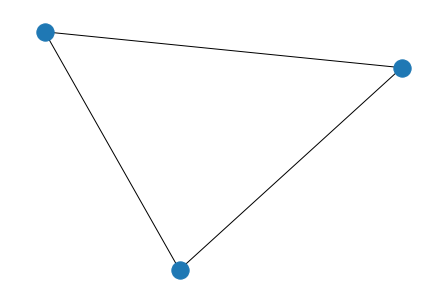

In [15]:
test_cycles[0].draw()

## Start SVM experiment

set up environment 

In [16]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from yellowbrick.model_selection import CVScores
from sklearn.model_selection import StratifiedKFold

## First experiment: MUTAG:

Load the data

In [17]:
dataset = TUDataset(root='data/TUDataset', name='MUTAG')

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')


Dataset: MUTAG(188):
Number of graphs: 188
Number of features: 7
Number of classes: 2

Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])


Inspect:

In [18]:
embd = GHC_Encoder(graph = dataset[0])
#embd.draw_graph()

len(list(embd.subIso(test_trees[0])))

38

Process the data

In [243]:
# For MUTAG in graph_tools with new library

# lables
y = np.array([x for x in itertools.chain.from_iterable((data.y.detach().numpy() for data in dataset))])

# vectors:
encode = lambda x: gt_Encoder(x, F_testlist, format ='numpy')
X = np.array([encode(data) for data in tqdm(dataset)])
#%timeit X = encode(dataset[0])
#encode(dataset[0])

100%|██████████| 188/188 [00:02<00:00, 74.02it/s]


### MUTAG with custom GHC encoder

In [31]:
# MUTA with custom GHC encoder

# lables
y = np.array([x for x in itertools.chain.from_iterable((data.y.detach().numpy() for data in dataset))])

# vectors:
add_testgraphs = lambda x: x.add_from_iter(F_testlist)

Encoded_Dataset = [GHC_Encoder(graph = data) for data in dataset]
f = list(map(add_testgraphs, Encoded_Dataset))
#Encoded_Dataset[0]
#X = np.array([data.default_encoder() for data in tqdm(Encoded_Dataset)])
#Encoded_Dataset[0].Agg_pullback_fast(F_testlist[0])
#%timeit Encoded_Dataset[0].fast_encoder()
#Encoded_Dataset[0].subIndx(F_testlist[0])
%timeit Encoded_Dataset[0].ghc_encoder()
#Encoded_Dataset[0].ghc_encoder()

AttributeError: ignored

In [524]:
def get_indx_r(g, sub, embedding):
    vmask, emask = gt_topology.mark_subgraph(g, sub, embedding)
    g.set_vertex_filter(vmask)
    vertices = g.get_vertices()
    g.set_vertex_filter(None)

    return vertices
def listofiso(data, testgraph):
    # returns a list of subgraphs testgraphs -> graph
    g = data.gt_graph()
    sub = testgraph.gt_graph()
    list_of_isos = gt_topology.subgraph_isomorphism(sub, g,
                                            max_n = testgraph.bound, 
                                            induced = data.induced)
    return list_of_isos
g = Encoded_Dataset[0].gt_graph()
sub = F_testlist[0].gt_graph()
lisss = listofiso(Encoded_Dataset[0], F_testlist[0])
indices = []
#for n in range(1):
#    indices.append(len(get_indx_r(g, sub, lisss[n])))

#indices 
#get_indx_r(g, sub, lisss[3])

e = lisss[1]
vmask, emask = gt_topology.mark_subgraph(g, sub, e)

g.set_vertex_filter(vmask)
x = g.get_vertices()
g.set_vertex_filter(None)
e = lisss[4]
vmask, emask = gt_topology.mark_subgraph(g, sub, e)

g.set_vertex_filter(vmask)
y = g.get_vertices()

x,y


(array([0, 5]), array([1, 2]))

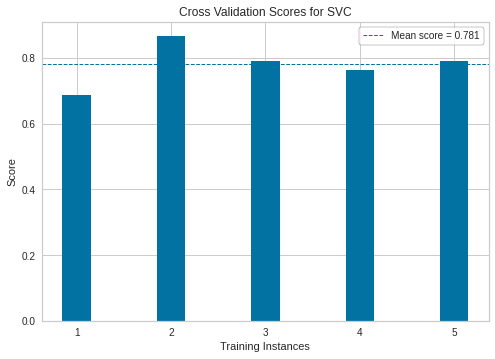

In [258]:
# Run classifier - MUTAG

clf = SVC(kernel='rbf')


cv = StratifiedKFold(n_splits=5, shuffle=True)
visualizer = CVScores(clf, cv=cv, scoring='f1_weighted', random_state=42)
visualizer.fit(X, y)        
visualizer.show()   


## Experiment: IMDB 

In [31]:
dataset = TUDataset(root='data/IMDB-BINARY', name='IMDB-BINARY')

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

ValueError: ignored

Inspect:

In [ ]:
to_kx = lambda x: uts.to_networkx(x,to_undirected = True)

G = to_kx(dataset[2])
#nx.draw(G)

dataset[2].y

tensor([0])

In [ ]:
# For IMDB-BIN in networkx

# lables
#y = np.array([x for x in itertools.chain.from_iterable((data.y.detach().numpy() for data in dataset))])

# vectors:
#encode = lambda x: Simple_Encoder(to_kx(x),F_list, line = False, format ='numpy')
#X = [encode(data) for data in tqdm(dataset)]
#%timeit X = encode(dataset[0])
#encode(dataset[6])

In [ ]:
# For IMDB-BIN in graph_tools

# lables
y = np.array([x for x in itertools.chain.from_iterable((data.y.detach().numpy() for data in dataset))])

# vectors:
encode = lambda x: gtEncoder(x, F_testlist_gt, format ='numpy')
#X = [encode(data) for data in tqdm(dataset)]
%timeit X = encode(dataset[0])
#encode(dataset[0])


10 loops, best of 5: 26.2 ms per loop


In [ ]:
# IMDB with new library

# lables
y = np.array([x for x in itertools.chain.from_iterable((data.y.detach().numpy() for data in dataset))])

# vectors:
encode = lambda x: gt_Encoder(x, F_testlist, format ='numpy')
#X = [encode(data) for data in tqdm(dataset)]
%timeit X = encode(dataset[0])
#encode(dataset[0])

10 loops, best of 5: 29 ms per loop


In [336]:
# IMDB with GHC Encoder

# lables
y = np.array([x for x in itertools.chain.from_iterable((data.y.detach().numpy() for data in dataset))])

# vectors:
add_testgraphs = lambda x: x.add_from_iter(F_testlist)

Encoded_Dataset = [GHC_Encoder(graph = data) for data in dataset]
list(map(add_testgraphs, Encoded_Dataset))

#X = np.array([data.default_encoder() for data in tqdm(Encoded_Dataset)])
#Encoded_Dataset[0].Agg_pullback_fast(F_testlist[0])
#%timeit Encoded_Dataset[0].fast_encoder()
Encoded_Dataset[0].fast_encoder()

TypeError: ignored

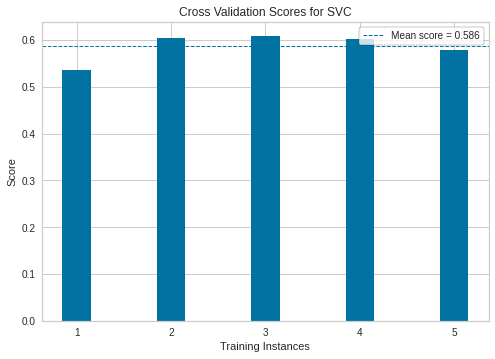

In [ ]:
# Run classifier - IMDB-BIN

clf = SVC(kernel='rbf')


cv = StratifiedKFold(n_splits=5, shuffle=True)
visualizer = CVScores(clf, cv=cv, scoring='f1_weighted', random_state=42)
visualizer.fit(X, y)        
visualizer.show()   

## Experiment: "ogbg-molhiv" 

In [536]:
dataset = PygGraphPropPredDataset(name = "ogbg-molhiv", root = 'dataset/')

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')


Dataset: PygGraphPropPredDataset(41127):
Number of graphs: 41127
Number of features: 9
Number of classes: 2

Data(edge_index=[2, 40], edge_attr=[40, 3], x=[19, 9], y=[1, 1], num_nodes=19)


In [ ]:
to_kx = lambda x: uts.to_networkx(x,to_undirected = True)

G = to_kx(dataset[0])
#nx.draw(G)
#dataset[1].edge_index
gt_Encoder(dataset[0], F_testlist)

tensor([ 40,  56,  72,  48, 100,  48,  24,   0,   0,   0,   0,   0,   0])

In [343]:
# HIV with new library

# lables
y = np.array([x for x in itertools.chain.from_iterable((data.y.detach().numpy() for data in dataset))])

# vectors:
#encode = lambda x: gt_Encoder(x, F_testlist, format ='numpy')
#X = [encode(data) for data in tqdm(dataset)]
#%timeit X = encode(dataset[0])
#encode(dataset[0])

# more vecs
add_testgraphs = lambda x: x.add_from_iter(F_testlist)

Encoded_Dataset = [gt_embedding(graph = data) for data in dataset]
list(map(add_testgraphs, Encoded_Dataset))

%timeit Encoded_Dataset[0].num_encoder()

100 loops, best of 5: 8.34 ms per loop


In [547]:
# HIV with GHC encoder

# lables
y = np.array([x for x in itertools.chain.from_iterable((data.y.detach().numpy() for data in dataset))])

# vectors:
add_testgraphs = lambda x: x.add_from_iter(F_testlist)

Encoded_Dataset = [GHC_Encoder(graph = data) for data in dataset]
f = list(map(add_testgraphs, Encoded_Dataset))

#X = np.array([data.num_encoder() for data in tqdm(Encoded_Dataset)])
#Encoded_Dataset[0].Agg_pullback_fast(F_testlist[0])
%timeit Encoded_Dataset[0].num_encoder()
#Encoded_Dataset[0].num_encoder()

100 loops, best of 5: 8.12 ms per loop


In [ ]:
y_fix = y[:,0]

IndexError: ignored

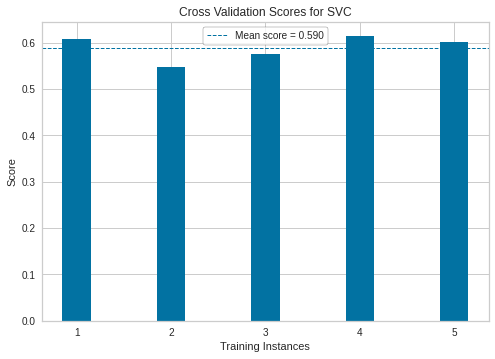

In [ ]:
# Run classifier - ogbg-molhiv

clf = SVC(kernel='rbf')


cv = StratifiedKFold(n_splits=5, shuffle=True)
visualizer = CVScores(clf, cv=cv, scoring='roc_auc', random_state=42)
visualizer.fit(X, y_fix)        
visualizer.show()   

## Zinc

In [ ]:
dataset = ZINC(root='data/ZINC',subset=True)

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')


Dataset: ZINC(10000):
Number of graphs: 10000
Number of features: 1
Number of classes: 9994

Data(x=[29, 1], edge_index=[2, 64], edge_attr=[64], y=[1])


Inspect:

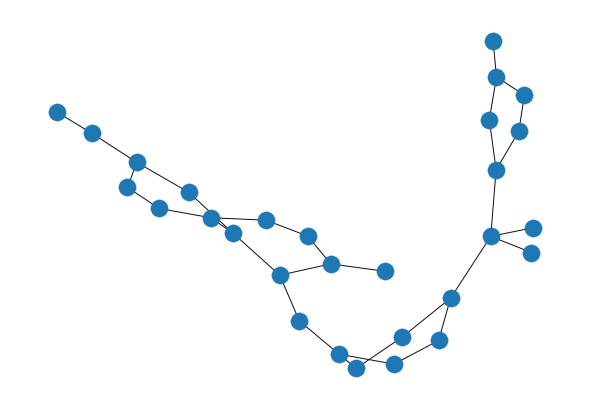

In [ ]:
to_kx = lambda x: uts.to_networkx(x,to_undirected = True)

G = to_kx(dataset[0])
nx.draw(G)


Some statistics on the data set:

## ogbg-code2